# Response to Stochastic Process input

we feed the neuron with spikes drawn from an inhomogeneous Poisson process whose time-varying rate is set by a temporally correlated stochastic process (Ornstein-Uhlenbeck process)

In [1]:
import numpy as np

import sys
from parallel import Parallel

sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt
sys.path.append('../../analyz')
from analyz.signal_library.stochastic_processes import OrnsteinUhlenbeck_Process
from analyz.processing.signanalysis import autocorrel, crosscorrel

/home/yann.zerlaut/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


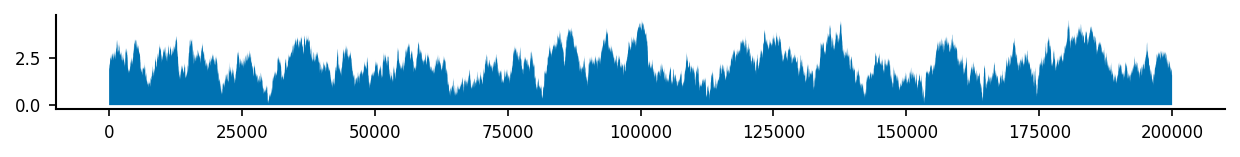

In [2]:
def OrnsteinUhlenbeck_Process(mu, sigma, tau, 
                              dt=0.1, tstop=100):
    """ taken from github.com/yzerlaut/analyz """
    diffcoef = 2*sigma**2/tau
    y0, n_steps= mu, int(tstop/dt)
    A = np.sqrt(diffcoef*tau/2.*(1-np.exp(-2*dt/tau)))
    noise, y = np.random.randn(n_steps), np.zeros(n_steps)
    y[0] = y0
    for i in range(n_steps-1):
        y[i+1] = y0 + (y[i]-y0)*np.exp(-dt/tau)+A*noise[i]
    return y
np.random.seed(1)
X = np.clip(OrnsteinUhlenbeck_Process(2, .75, 50, dt=0.025, tstop=5e3), 0, np.inf)
fig, ax = pt.figure(figsize=(3,1))
ax.fill_between(range(len(X)), 0*X, X)

In [3]:
# Gaussian Fit

from scipy.optimize import minimize

def gaussian(t, X):
    return (1-X[2])*(1/(1+((t-X[1])/X[0])**2))+X[2]
                 
def fit_gaussian_width(shift, array,
                       min_time=10,
                       max_time=1000):
    def func(X):
        return np.sum(np.abs(gaussian(shift, X)-array))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [-1,1]], method='L-BFGS-B')
    return res.x

In [16]:
from scipy.ndimage import gaussian_filter1d

rate_smoothing = 10. # ms

# (3,4) ok
RESULTS = {'Martinotti_example_index':32,
           'Basket_example_index':47} # 4, 11 ok, 13 good
RESULTS = {'Martinotti_example_index':0,
           'Basket_example_index':0}

#for cellType in ['Martinotti', 'Basket', 'MartinottinoNMDA', 'BasketUniform']:
for cellType in ['Martinotti', 'Basket']:

    sim = Parallel(\
            filename='../../data/detailed_model/tvRateStim_demo_%s.zip' % cellType)
    sim.load()

    sim.fetch_quantity_on_grid('spikes', dtype=list)

    seeds = np.unique(sim.spikeSeed)

    dt = sim.fetch_quantity_on_grid('dt', return_last=True)
    tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)

    spikes_matrix= np.zeros((len(seeds), int(tstop/dt)+1))
    RESULTS['%s_rate' % cellType] = []
    for i, spikes in enumerate(sim.spikes):
        spikes_matrix[i,(spikes/dt).astype('int')] = True
    RESULTS['rate_%s' % cellType] = 1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                           int(rate_smoothing/dt))
    

    RESULTS['stimFreq_%s' % cellType] = sim.fetch_quantity_on_grid('stimFreq', return_last=True)
    RESULTS['bgFreqInhFactor_%s' % cellType] = sim.fetch_quantity_on_grid('bgFreqInhFactor', return_last=True)

    sim.fetch_quantity_on_grid('OU', return_last=True, dtype=np.ndarray)
    RESULTS['Input_%s' % cellType] = sim.OU[0]
    
    if '%s_example_index' % cellType in RESULTS:
        sim.fetch_quantity_on_grid('Vm_soma', return_last=True, dtype=np.ndarray)
        RESULTS['Vm_%s' % cellType] = sim.Vm_soma[RESULTS['%s_example_index' % cellType]]
        sim.fetch_quantity_on_grid('presynaptic_exc_events', dtype=list)
        RESULTS['pre_exc_%s' % cellType] = sim.presynaptic_exc_events[RESULTS['%s_example_index' % cellType]]
        sim.fetch_quantity_on_grid('presynaptic_inh_events', dtype=list)
        RESULTS['pre_inh_%s' % cellType] = sim.presynaptic_inh_events[RESULTS['%s_example_index' % cellType]]
        
    RESULTS['t'] = np.arange(len(RESULTS['rate_%s' % cellType]))*dt
    RESULTS['dt'] = dt
    print(cellType, '%.2f Hz' % np.mean(RESULTS['rate_%s' % cellType][RESULTS['t']>2e3]))

Martinotti 27.87 Hz
Basket 11.01 Hz


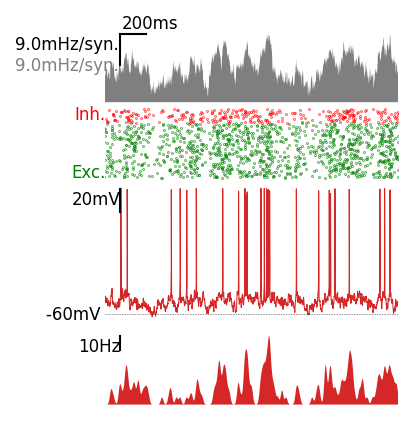

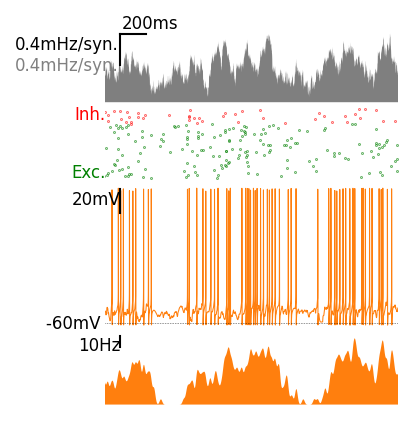

In [17]:
zoom = [1.25e3, 3.5e3]

for cellType, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):

    fig, AX = pt.figure(axes_extents=[[(1,1)],[(1,1)],[(1,2)],[(1,1)]],
                        figsize=(1.5,0.8), left=0, bottom=0., hspace=0.)

    # input
    AX[0].fill_between(RESULTS['t'][:-1][::20], 0*RESULTS['t'][:-1][::20], RESULTS['Input_%s' % cellType][::20],
                       color='tab:grey', lw=0)

    # Vm
    AX[2].plot(RESULTS['t'][::10], RESULTS['Vm_%s' % cellType][::10], color=color, lw=0.5)
    AX[2].plot(RESULTS['t'][::100], -60+0*RESULTS['t'][::100], 'k:', lw=0.3)

    # rate
    if RESULTS['rate_%s' % cellType] is not None:
        AX[3].fill_between(RESULTS['t'][::20], 0*RESULTS['t'][::20], RESULTS['rate_%s' % cellType][::20],
                           color=color, lw=0)
        
    # events
    if 'pre_inh_%s'%cellType in RESULTS:
        subsampling = 10 # if cellType=='Basket' else 1
        # 1/4 for display
        for i, events in enumerate(RESULTS['pre_exc_%s' % cellType]):
            AX[1].plot(events[::subsampling], i*np.ones(len(events))[::subsampling], '.', color='g', ms=.5)
        for i, events in enumerate(RESULTS['pre_inh_%s' % cellType]):
            AX[1].plot(events[::subsampling], 
                       len(RESULTS['pre_exc_%s' % cellType])+i*np.ones(len(events))[::subsampling], '.', 
                       color='r', ms=.5)

    pt.set_common_xlims(AX, lims=zoom)
    
    pt.draw_bar_scales(AX[0], Xbar=200, Xbar_label='200ms', Ybar=2,
                       Ybar_label='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]),
                       Ybar_label2='%.1fmHz/syn.' % (2*1e3*RESULTS['stimFreq_%s' % cellType]*RESULTS['bgFreqInhFactor_%s' % cellType]))
    pt.annotate(AX[2], '-60mV ', (zoom[0],-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[2], Xbar=1e-12, Ybar=20,Ybar_label='20mV')
    pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
    for ax in AX:
        ax.axis('off')
    pt.draw_bar_scales(AX[3], Xbar=1e-12, Ybar=10,Ybar_label='10Hz')
    fig.savefig('../../figures/Figure5/StochProcSim_example_%s.svg' % cellType)

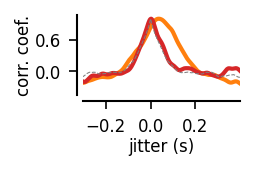

In [18]:
fig, ax = pt.figure(figsize=(1.1,0.85))
subsampling = 100
CCs = {}

for cellType, color in zip(['Martinotti', 'Basket'],#, 'MartinottinoNMDA'],
                           ['tab:orange', 'tab:red', 'tab:purple']):

    cond = RESULTS['t']>1

    
    cond = RESULTS['t']>1e3
    CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                          RESULTS['rate_%s' % cellType][1:][cond[1:]][::subsampling], 
                          400, subsampling*RESULTS['dt'])
    """
    # gaussian fit
    ax.plot(time_shift/1e3, 
            gaussian(time_shift,
                     fit_gaussian_width(time_shift, CCF/np.max(CCF))), '--', lw=0.5)
    """
    
    ax.plot(time_shift/1e3, CCF/np.max(CCF), color=color, lw=2)
    CCs['%s_CC' % cellType] = CCF
    
    CCs['time_shift'] = time_shift
    
    # input
    if cellType=='Basket':
        CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                              RESULTS['Input_%s' % cellType][cond[1:]][::subsampling], 
                              400, subsampling*RESULTS['dt'])
        CCs['Input_CC'] = CCF
        ax.plot(time_shift/1e3, CCF, '--', color='tab:grey', lw=0.5)

pt.set_plot(ax, xlabel='jitter (s)', 
            ylabel='corr. coef.',
            #yticks=[0.2,0.5,0.8],
            xlim=[-0.3,0.4],
            xticks=[-0.2,0,0.2])
fig.savefig('../../figures/Figure5/CrossCorrel-Model.svg')

In [ ]:
# Exponential fit to quantify the decay


fig, ax = pt.figure(figsize=(0.8,0.85))

for k, cellType, color in zip(range(3),
                              ['Basket', 'Martinotti', 'MartinottinoNMDA'],
                              ['tab:red', 'tab:orange', 'tab:purple']):

    i0 = int(len(CCs['time_shift'])/2)
    
    #tau = fit_exponential_decay(CCs['time_shift'][i0:], CCs['%s_CC' % cellType][i0:]/CCs['%s_CC' % cellType][i0])
    tau = fit_gaussian_width(CCs['time_shift'], CCs['%s_CC' % cellType]/np.max(CCs['%s_CC' % cellType]))[0]
    ax.bar([1+k], [tau], color=color)

    if cellType=='Basket':
        tau = fit_gaussian_width(CCs['time_shift'], CCs['Input_CC']/np.max(CCs['Input_CC']))[0]
        ax.bar([0], [tau], color='tab:grey')
    

    #ax11.bar([k], [CCF[int(len(time_shift)/2)]], color=pos_color)
    
    #plt.plot(ts, np.exp(-ts/tau), color=color)
#pt.set_plot(ax, yticks=[0,50,100])

pt.set_plot(ax, ['left'], yticks=[0,50,100],
            ylabel=u'\u00bd' + ' width\n(ms)')
fig.savefig('../../figures/detailed_model/Widths.svg')

## Analysis over different seeds

In [6]:
from scipy.ndimage import gaussian_filter1d

rate_smoothing = 10. # ms
subsampling = 100

RESULTS = {} # 4, 11 ok, 13 good

for cellType in ['Martinotti', 'Basket', 'MartinottinoNMDA']:

    RESULTS['rate_%s' % cellType] = []
    RESULTS['Input_%s' % cellType] = []
    RESULTS['CC_%s' % cellType] = [] # cross-correl
    RESULTS['AC_%s' % cellType] = [] # auto-correl
    
    for iBranch in range(6):
        
        sim = Parallel(\
                filename='../../data/detailed_model/tvRateStim_simBranch%i_%s.zip' % (iBranch,cellType))
        sim.load()

        sim.fetch_quantity_on_grid('spikes', dtype=list)
        sim.fetch_quantity_on_grid('OU', dtype=np.ndarray)

        spikeSeeds = np.unique(sim.spikeSeed)
        stochProcSeeds = np.unique(sim.stochProcSeed)
        
        dt = sim.fetch_quantity_on_grid('dt', return_last=True)
        tstop = sim.fetch_quantity_on_grid('tstop', return_last=True)
        t = np.arange(int(tstop/dt)+1)*dt
        
        for stochProcSeed in stochProcSeeds:
            cond = sim.stochProcSeed==stochProcSeed
            
            # fetch input
            RESULTS['Input_%s' % cellType].append(sim.OU[cond][0])
            # compute rate
            spikes_matrix= np.zeros((len(spikeSeeds), int(tstop/dt)+1))
            for i, spikes in enumerate(sim.spikes[cond]):
                spikes_matrix[i,(spikes/dt).astype('int')] = True
            # store rate
            RESULTS['rate_%s' % cellType].append(1e3*gaussian_filter1d(np.mean(spikes_matrix, axis=0)/dt,
                                                                       int(rate_smoothing/dt)))
            
            tCond = t[1:]>1e3 # remove initial transients
            
            # compute Cross-Correl
            CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][-1][tCond][::subsampling], 
                                          RESULTS['rate_%s' % cellType][-1][1:][tCond][::subsampling], 
                                          400, subsampling*dt)
            RESULTS['CC_%s' % cellType].append(CCF)
            
            # compute Auto-Correl
            CCF, time_shift = crosscorrel(RESULTS['Input_%s' % cellType][-1][tCond][::subsampling], 
                                          RESULTS['Input_%s' % cellType][-1][tCond][::subsampling], 
                                          400, subsampling*dt)
            RESULTS['AC_%s' % cellType].append(CCF)
        #print('%s, branch #%i, mean rate %.1f' % (cellType, iBranch,
        #                                          np.mean(RESULTS['rate_%s' % cellType])))
    print('%s, mean rate %.1f +/- %.1f Hz' % (cellType,
                                              np.mean(np.mean(RESULTS['rate_%s' % cellType], axis=0)),
                                              np.std(np.mean(RESULTS['rate_%s' % cellType], axis=0))))
        
    RESULTS['t'] = t
    RESULTS['dt'] = dt
    RESULTS['time_shift'] = time_shift

Martinotti, mean rate 9.8 +/- 4.5 Hz
Basket, mean rate 10.0 +/- 3.9 Hz
MartinottinoNMDA, mean rate 4.5 +/- 2.2 Hz


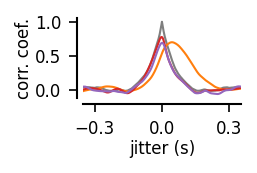

In [10]:
from scipy import stats

fig, ax = pt.figure(figsize=(1.1,0.85))
subsampling = 100

for cellType, color in zip(['Martinotti', 'Basket', 'MartinottinoNMDA'],
                           ['tab:orange', 'tab:red', 'tab:purple']):

    cond = RESULTS['t']>1

    # input
    if cellType=='Martinotti':
        pt.plot(RESULTS['time_shift']/1e3, 
                np.nanmean(RESULTS['AC_%s' % cellType], axis=0),
                #sy=stats.sem(RESULTS['AC_%s' % cellType], axis=0),
                ax=ax, no_set=True, color='tab:grey')
    
    pt.plot(RESULTS['time_shift']/1e3, 
            np.nanmean(RESULTS['CC_%s' % cellType], axis=0),
            #sy=stats.sem(RESULTS['CC_%s' % cellType], axis=0),
            ax=ax, no_set=True, color=color)

pt.set_plot(ax, xlabel='jitter (s)', 
            ylabel='corr. coef.',
            yticks=[0.,0.5,1.0],
            xlim=[-0.35,0.35],
            xticks=[-0.3,0,0.3])
fig.savefig('../../figures/detailed_model/CrossCorrel.svg')

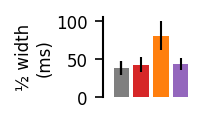

In [9]:
# Exponential fit to quantify the decay

fig, ax = pt.figure(figsize=(0.8,0.85))

RESULTS['tauAC'] = [] # auto-correl
for k, cellType, color in zip(range(3),
                              ['Basket', 'Martinotti', 'MartinottinoNMDA'],
                              ['tab:red', 'tab:orange', 'tab:purple']):

    
    RESULTS['tauCC_%s' % cellType] = [] # cross-correl

    if k==0:
        for AC in RESULTS['AC_%s' % cellType]:
            tau = fit_gaussian_width(RESULTS['time_shift'],
                                     AC/np.max(AC))[0]
            RESULTS['tauAC'].append(tau)
    ax.bar([0], 
           [np.mean(RESULTS['tauAC'])],
           yerr=[np.std(RESULTS['tauAC'])],
           color='tab:grey')
    
    for CC in RESULTS['CC_%s' % cellType]:
        tau = fit_gaussian_width(RESULTS['time_shift'],
                                 CC/np.max(CC))[0]
        RESULTS['tauCC_%s' % cellType].append(tau)
        
    ax.bar([1+k], 
           [np.mean(RESULTS['tauCC_%s' % cellType])],
           yerr=[np.std(RESULTS['tauCC_%s' % cellType])],
           color=color)

pt.set_plot(ax, ['left'], yticks=[0,50,100],
            ylabel=u'\u00bd' + ' width\n(ms)')
fig.savefig('../../figures/detailed_model/Widths.svg')

## Compute cross-correlation functions

In [ ]:
subsampling = 20
for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    RESULTS['%s_CCs' % cellType] = []
    for s in range(len(seeds)):
        CCF, ts = crosscorrel(RESULTS['%s_rates' % cellType][s][1:][::subsampling],
                              RESULTS['StochProc'][s][::subsampling], 
                              1e3, subsampling*dt)
        RESULTS['%s_CCs' % cellType].append(CCF)
    
RESULTS['CC_StochProc'] = []
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc[::subsampling], sc[::subsampling],
                          1e3, subsampling*dt)
    RESULTS['CC_StochProc'].append(CCF)

### plot

In [ ]:
fig, ax = pt.figure(figsize=(2,3))

for c, cellType, color in zip(range(2), ['Martinotti', 'Basket'], ['tab:orange', 'tab:red']):
    pt.plot(ts, np.mean(RESULTS['%s_CCs' % cellType], axis=0),
             sy=stats.sem(RESULTS['%s_CCs' % cellType], axis=0),
             color=color, ax=ax)  
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)
    
#pt.set_plot(ax, xlim=[-1000,1000])

In [ ]:
for sc in RESULTS['StochProc']:
    CCF, ts = crosscorrel(sc, sc,
                          1e3, subsampling*RESULTS['dt'])
    RESULTS['CC_StochProc'].append(CCF)
pt.plot(ts, np.mean(RESULTS['CC_StochProc'], axis=0),
        sy=stats.sem(RESULTS['CC_StochProc'], axis=0),
        color='tab:grey', ax=ax)


In [ ]:
RESULTS['CC_StochProc']